<a href="https://colab.research.google.com/github/RohEunSeo/LGAimers/blob/main/CatBoost_Optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
from pprint import pprint
!pip install catBoost
!pip install optuna
from catboost import CatBoostClassifier, Pool

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import(
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from tqdm import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.0 MB/s eta 0:00:00


# train 데이터 불러오기

In [3]:
ROOT_DIR = "/content/drive/MyDrive/lgAimers.5(updated.ver)/modeling"
RANDOM_STATE = 110

#데이터 불러오기
train_data = pd.read_csv(os.path.join(ROOT_DIR, "train_data_cleaned(스케일링후).csv"))
train_data

,Process Desc._Dam,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE STANDBY POSITION X Collect Result_Dam,CURE STANDBY POSITION Z Collect Result_Dam,...,Head Clean Position X Collect Result_Fill2,Head Clean Position Y Collect Result_Fill2,Head Clean Position Z Collect Result_Fill2,Head Purge Position X Collect Result_Fill2,Head Purge Position Y Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,Production Qty Collect Result_Fill2,WorkMode Collect Result_Fill2,target
0,Dam Dispenser,Dam dispenser #1,AJX75334505,4F1XA938-1,0.0,0.0,0.0,0.857143,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.364023,0.014374,0.058824,Normal
1,Dam Dispenser,Dam dispenser #1,AJX75334505,3KPM0016-2,0.0,0.0,0.0,0.000000,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,0.007505,0.379877,0.000000,Normal
2,Dam Dispenser,Dam dispenser #2,AJX75334501,4E1X9167-1,1.0,1.0,1.0,0.428571,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.364023,0.020534,0.058824,Normal
3,Dam Dispenser,Dam dispenser #2,AJX75334501,3K1X0057-1,1.0,1.0,1.0,0.000000,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,0.008630,0.550308,0.000000,Normal
4,Dam Dispenser,Dam dispenser #1,AJX75334501,3HPM0007-1,0.0,0.0,0.0,0.000000,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,0.007880,0.248460,0.000000,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40094,Dam Dispenser,Dam dispenser #1,AJX75334501,3J1XF434-2,0.0,0.0,0.0,0.000000,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,0.006004,0.652977,0.000000,Normal
40095,Dam Dispenser,Dam dispenser #2,AJX75334501,4E1XC796-1,1.0,1.0,1.0,0.857143,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.364023,0.028747,0.058824,Normal
40096,Dam Dispenser,Dam dispenser #1,AJX75334501,4C1XD438-1,0.0,0.0,0.0,0.857143,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.252908,0.002053,0.058824,Normal
40097,Dam Dispenser,Dam dispenser #2,AJX75334501,3I1XA258-1,1.0,1.0,1.0,0.000000,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,0.009381,0.240246,0.000000,Normal


# 언더 샘플링(Normal 데이터 추가 샘플링, (3489,2326)

In [4]:
# 언더 샘플링 비율 조정
normal_ratio = 1.0
additional_ratio = 0.5  # 추가로 유지할 Normal 데이터의 비율

df_normal = train_data[train_data["target"] == "Normal"]
df_abnormal = train_data[train_data["target"] == "AbNormal"]

num_normal = len(df_normal)
num_abnormal = len(df_abnormal)
print(f"  Total: Normal: {num_normal}, AbNormal: {num_abnormal}")

# 언더 샘플링: Normal 데이터를 AbNormal 데이터 수와 맞춤
df_normal_sampled = df_normal.sample(n=int(num_abnormal * normal_ratio), replace=False, random_state=RANDOM_STATE)

# 추가로 일부 Normal 데이터를 유지
df_additional_normal = df_normal.sample(n=int(num_abnormal * additional_ratio), replace=False, random_state=RANDOM_STATE)

# 최종 데이터셋 결합
df_concat = pd.concat([df_normal_sampled, df_additional_normal, df_abnormal], axis=0).reset_index(drop=True)

# 결과 확인
print(df_concat.value_counts("target"))  # Normal 추가 학습 시 점수 올랐음

  Total: Normal: 37774, AbNormal: 2325
target
Normal      3487
AbNormal    2325
Name: count, dtype: int64


# 베이스라인 언더 샘플링코드

In [5]:
# 언더 샘플링 비율 조정
'''normal_ratio = 1.0

df_normal = train_data[train_data["target"] == "Normal"]
df_abnormal = train_data[train_data["target"] == "AbNormal"]

num_normal = len(df_normal)
num_abnormal = len(df_abnormal)
print(f"  Total: Normal: {num_normal}, AbNormal: {num_abnormal}")

df_normal = df_normal.sample(n=int(num_abnormal * normal_ratio), replace=False, random_state=RANDOM_STATE)
df_concat = pd.concat([df_normal, df_abnormal], axis=0).reset_index(drop=True)
df_concat.value_counts("target")'''

'normal_ratio = 1.0\n\ndf_normal = train_data[train_data["target"] == "Normal"]\ndf_abnormal = train_data[train_data["target"] == "AbNormal"]\n\nnum_normal = len(df_normal)\nnum_abnormal = len(df_abnormal)\nprint(f"  Total: Normal: {num_normal}, AbNormal: {num_abnormal}")\n\ndf_normal = df_normal.sample(n=int(num_abnormal * normal_ratio), replace=False, random_state=RANDOM_STATE)\ndf_concat = pd.concat([df_normal, df_abnormal], axis=0).reset_index(drop=True)\ndf_concat.value_counts("target")'

# 데이터 분할 : train_test_split



In [6]:
df_train, df_val = train_test_split(
    df_concat,
    test_size=0.2,
    stratify=df_concat["target"],
    random_state=RANDOM_STATE,
    #shuffle=True
)


def print_stats(df: pd.DataFrame):
    num_normal = len(df[df["target"] == "Normal"])
    num_abnormal = len(df[df["target"] == "AbNormal"])

    print(f"  Total: Normal: {num_normal}, AbNormal: {num_abnormal}" + f" ratio: {num_abnormal/num_normal}")


# Print statistics
print(f"  \tAbnormal\tNormal")
print_stats(df_train)
print_stats(df_val)

  	Abnormal	Normal
  Total: Normal: 2789, AbNormal: 1860 ratio: 0.6669057009680889
  Total: Normal: 698, AbNormal: 465 ratio: 0.666189111747851


In [7]:
# 학습 데이터에서 target을 제외한 features 리스트 정의
features = [col for col in df_train.columns if col != 'target']
# 학습 데이터에서 cat_features 인덱스 리스트 정의
cat_features = [i for i, col in enumerate(features) if df_train[col].dtype == 'object']

# train_x와 train_y 설정
train_x = df_train[features]
train_y = df_train["target"]

# 검증 데이터셋 설정
val_x = df_val[features]
val_y = df_val["target"]

# Label Encoding

In [8]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_y_encoded = label_encoder.fit_transform(train_y)

# optuna 가중치 클래스 최적화

In [9]:
'''import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold
from catboost import CatBoostClassifier

# 이미 구한 최적의 하이퍼파라미터 (이전에 얻은 값을 사용)
hyperparams = {
    'learning_rate': 0.03267157216048974,
    'colsample_bylevel': 0.42493185229343566,
    'depth': 3,
    'boosting_type': 'Plain',
    'iterations': 804,
    'l2_leaf_reg': 6.7010000000000005,
    'min_child_samples': 3,
    'border_count': 101,
    'bootstrap_type': 'MVS',
    'leaf_estimation_iterations': 1,
    'leaf_estimation_method': 'Gradient',
    'loss_function': 'Logloss'  # Logloss로 설정
}

# Optuna 목적 함수 정의
def objective(trial):
    # class_weights를 수치형 범위에서 최적화
    class_weight_abnormal = trial.suggest_float('class_weight_abnormal', 0.5, 5.0)
    class_weight_normal = trial.suggest_float('class_weight_normal', 0.5, 5.0)
    class_weights = [class_weight_abnormal, class_weight_normal]

    model = CatBoostClassifier(
        learning_rate=hyperparams['learning_rate'],
        colsample_bylevel=hyperparams['colsample_bylevel'],
        depth=hyperparams['depth'],
        boosting_type=hyperparams['boosting_type'],
        iterations=hyperparams['iterations'],
        l2_leaf_reg=hyperparams['l2_leaf_reg'],
        min_child_samples=hyperparams['min_child_samples'],
        border_count=hyperparams['border_count'],
        bootstrap_type=hyperparams['bootstrap_type'],
        leaf_estimation_iterations=hyperparams['leaf_estimation_iterations'],
        leaf_estimation_method=hyperparams['leaf_estimation_method'],
        loss_function=hyperparams['loss_function'],  # Logloss로 설정
        class_weights=class_weights,  # 클래스 가중치 추가
        random_seed=110,
        verbose=0,
        cat_features=cat_features
    )

    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=110)
    # 초기 train_x와 train_y를 사용하여 교차 검증
    score = cross_val_score(model, train_x, train_y_encoded, cv=stratified_kfold, scoring='f1_macro').mean()

    return score

# Optuna 스터디 생성
study = optuna.create_study(direction='maximize', study_name='ClassWeightOptimization')
study.optimize(objective, n_trials=50, n_jobs=-1)

# 최적의 클래스 가중치 출력
best_class_weights = study.best_trial.params
print("Best class weights found: ", best_class_weights)'''


'import optuna\nfrom sklearn.model_selection import cross_val_score, StratifiedKFold\nfrom catboost import CatBoostClassifier\n\n# 이미 구한 최적의 하이퍼파라미터 (이전에 얻은 값을 사용)\nhyperparams = {\n    \'learning_rate\': 0.03267157216048974,\n    \'colsample_bylevel\': 0.42493185229343566,\n    \'depth\': 3,\n    \'boosting_type\': \'Plain\',\n    \'iterations\': 804,\n    \'l2_leaf_reg\': 6.7010000000000005,\n    \'min_child_samples\': 3,\n    \'border_count\': 101,\n    \'bootstrap_type\': \'MVS\',\n    \'leaf_estimation_iterations\': 1,\n    \'leaf_estimation_method\': \'Gradient\',\n    \'loss_function\': \'Logloss\'  # Logloss로 설정\n}\n\n# Optuna 목적 함수 정의\ndef objective(trial):\n    # class_weights를 수치형 범위에서 최적화\n    class_weight_abnormal = trial.suggest_float(\'class_weight_abnormal\', 0.5, 5.0)\n    class_weight_normal = trial.suggest_float(\'class_weight_normal\', 0.5, 5.0)\n    class_weights = [class_weight_abnormal, class_weight_normal]\n\n    model = CatBoostClassifier(\n        learning_rat

# optuna 하이퍼파라미터

In [10]:
hyperparams = {
  'learning_rate': 0.03267157216048974,
  'colsample_bylevel': 0.42493185229343566,
  'depth': 3,
  'boosting_type': 'Plain',
  'iterations': 804,
  'l2_leaf_reg': 6.7010000000000005,
  'min_child_samples': 3,
  'border_count': 101,
  'bootstrap_type': 'MVS',
  'leaf_estimation_iterations': 1,
  'leaf_estimation_method': 'Gradient',
  'loss_function': 'CrossEntropy'}

In [11]:
# 학습 데이터에서 target을 제외한 features 리스트 정의
features = [col for col in df_train.columns if col != 'target']
# 학습 데이터에서 cat_features 인덱스 리스트 정의
cat_features = [i for i, col in enumerate(features) if df_train[col].dtype == 'object']

# train_x와 train_y 설정
train_x = df_train[features]
train_y = df_train["target"]
train_y_encoded = label_encoder.fit_transform(train_y)

In [12]:
# 최적 하이퍼파라미터로 모델 설정 및 재학습
best_model = CatBoostClassifier(**hyperparams, cat_features=cat_features)

# 필터링된 학습 데이터로 모델 재학습
best_model.fit(train_x, train_y_encoded, cat_features=cat_features)

0:	learn: 0.6926076	total: 52.8ms	remaining: 42.4s
1:	learn: 0.6920790	total: 60.9ms	remaining: 24.4s
2:	learn: 0.6915366	total: 67.3ms	remaining: 18s
3:	learn: 0.6909764	total: 73.4ms	remaining: 14.7s
4:	learn: 0.6904381	total: 78.3ms	remaining: 12.5s
5:	learn: 0.6899162	total: 85.9ms	remaining: 11.4s
6:	learn: 0.6894263	total: 93.8ms	remaining: 10.7s
7:	learn: 0.6889612	total: 101ms	remaining: 10.1s
8:	learn: 0.6884503	total: 111ms	remaining: 9.8s
9:	learn: 0.6879629	total: 119ms	remaining: 9.48s
10:	learn: 0.6875460	total: 126ms	remaining: 9.1s
11:	learn: 0.6870913	total: 137ms	remaining: 9.06s
12:	learn: 0.6865950	total: 153ms	remaining: 9.32s
13:	learn: 0.6861048	total: 161ms	remaining: 9.08s
14:	learn: 0.6856712	total: 166ms	remaining: 8.75s
15:	learn: 0.6852591	total: 172ms	remaining: 8.49s
16:	learn: 0.6848531	total: 177ms	remaining: 8.21s
17:	learn: 0.6843913	total: 183ms	remaining: 7.97s
18:	learn: 0.6839647	total: 190ms	remaining: 7.83s
19:	learn: 0.6835699	total: 194ms	rema

# 모델 재학습 : Optuna

# 피처 중요도 계산 및 시각화

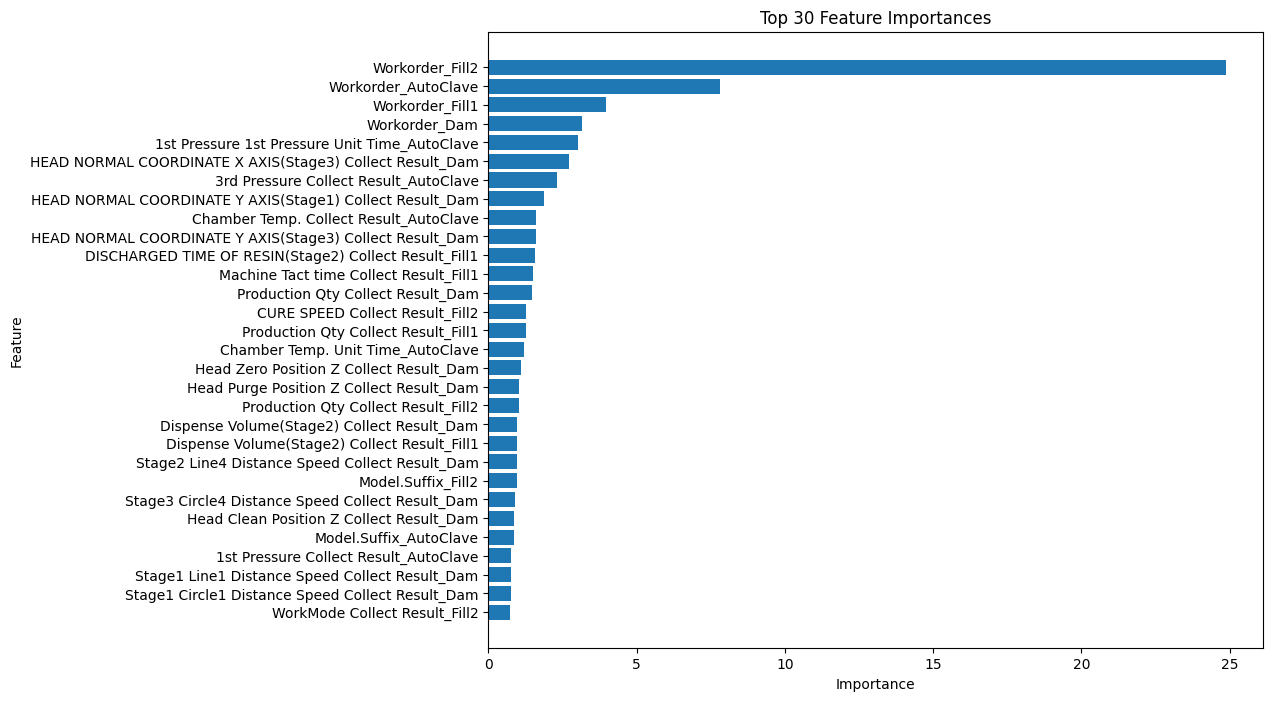

In [13]:
import matplotlib.pyplot as plt
# 피처 중요도 계산
feature_importances = best_model.get_feature_importance()

# 중요도와 피처 이름을 함께 정리
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 상위 30개의 피처 선택
top_30_features = importance_df.head(30)

# 피처 중요도 시각화
plt.figure(figsize=(10, 8))
plt.barh(top_30_features['Feature'], top_30_features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 30 Feature Importances')
plt.gca().invert_yaxis()  # 중요도가 높은 피처가 위에 오도록 y축을 반전
plt.show()



# 중요도 0.5% 이하 피처 필터링

In [14]:
import matplotlib.pyplot as plt
# 피처 중요도 계산
feature_importances = best_model.get_feature_importance()

# 중요도와 피처 이름을 함께 정리
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 중요도가 0.5 이하인 피처 필터링
low_importance_threshold = 0.5 # 임계값을 0.5로 설정
low_importance_features = importance_df[importance_df['Importance'] < low_importance_threshold]['Feature']

# 피처 중요도 낮은 열 삭제(전체 중요도의 0.5%이내인 피처)

In [15]:
# 중요도가 낮은 피처를 학습 데이터와 테스트 데이터에서 제거
train_x_filtered = train_x.drop(columns = low_importance_features)
train_x_filtered

,Workorder_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,Dispense Volume(Stage1) Collect Result_Dam,Dispense Volume(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam,Head Clean Position Z Collect Result_Dam,...,Dispense Volume(Stage2) Collect Result_Fill1,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1,Machine Tact time Collect Result_Fill1,Production Qty Collect Result_Fill1,Model.Suffix_Fill2,Workorder_Fill2,CURE SPEED Collect Result_Fill2,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2,Production Qty Collect Result_Fill2,WorkMode Collect Result_Fill2
205,4B1XC554-1,0.338983,0.167665,0.470588,0.779363,0.352428,0.988948,0.989873,0.036364,0.000000,...,0.025408,0.997208,0.724195,0.028747,AJX75334501,4B1XC554-1,0.285714,1.000000,0.028747,0.058824
3257,4B1X9671-1,0.305085,0.149701,0.441176,0.771210,0.000000,0.000663,0.000000,0.692091,0.000000,...,0.034483,0.001117,0.724195,0.004107,AJX75334501,4B1X9671-1,0.285714,0.000112,0.004107,0.058824
4290,3H1XE642-1,0.008475,0.000000,0.117647,0.001274,0.195773,0.000000,0.000393,0.981818,1.000000,...,0.034483,0.001452,0.409579,0.032854,AJX75334501,3H1XE642-1,0.285714,0.000000,0.032854,0.000000
427,4A1XA642-1,0.305085,0.149701,0.397059,0.780127,0.352698,0.988948,0.989873,0.644909,0.000000,...,0.034483,0.997208,0.724195,0.028747,AJX75334501,4A1XA642-1,0.285714,1.000000,0.028747,0.058824
0,4B1XE007-1,0.296610,0.143713,0.470588,0.779363,0.352428,0.988948,0.989873,0.036364,0.000000,...,0.034483,0.997208,0.724195,0.030801,AJX75334501,4B1XE007-1,0.285714,1.000000,0.030801,0.058824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919,3K1X7331-1,0.991525,0.491018,0.470588,1.000000,1.000000,0.987732,0.879658,0.759091,0.960741,...,0.034483,0.997543,0.146160,0.049281,AJX75334502,3K1X7331-1,0.285714,1.000000,0.049281,0.000000
3541,3F1X9644-1,0.008475,0.000000,0.014706,0.002548,0.195773,0.000000,0.000393,1.000000,0.866667,...,0.155172,0.001117,0.417836,0.205339,AJX75334501,3F1X9644-1,0.314286,0.000000,0.205339,0.000000
1450,3G1X8646-1,0.008475,0.000000,0.014706,0.002548,0.195773,0.000000,0.000393,1.000000,1.000000,...,0.155172,0.001117,0.422791,0.804928,AJX75334501,3G1X8646-1,0.285714,0.000000,0.804928,0.000000
3483,3M1XB515-1,0.296610,0.467066,0.676471,0.783694,0.354137,0.988948,0.878576,0.759091,0.000000,...,0.120690,0.997208,0.864575,0.022587,AJX75334501,3M1XB515-1,0.285714,1.000000,0.022587,0.058824


# test 데이터 불러오기

In [16]:
test_data = pd.read_csv(os.path.join(ROOT_DIR, "test_data_cleaned(스케일링후).csv"))

# 최종 모델 재학습 - Optuna

In [17]:
df_test_x_filtered = test_data[train_x_filtered.columns.intersection(test_data.columns)]

# 학습 데이터와 동일한 순서로 테스트 데이터의 피처 정렬
df_test_x_filtered = df_test_x_filtered.reindex(columns=train_x_filtered.columns, fill_value=0)

# 최적 하이퍼파라미터로 모델 설정 및 재학습
best_model_filtered = CatBoostClassifier(**hyperparams, cat_features=[i for i, col in enumerate(train_x_filtered.columns) if train_x_filtered[col].dtype == 'object'])

# 필터링된 학습 데이터로 모델 재학습
best_model_filtered.fit(train_x_filtered, train_y_encoded)

# CatBoost에서 사용할 Pool 객체 생성 (범주형 열 지정)
test_pool_filtered = Pool(df_test_x_filtered, cat_features=[i for i, col in enumerate(df_test_x_filtered.columns) if df_test_x_filtered[col].dtype == 'object'])

# 최적 모델로 예측 수행
test_pred_filtered = best_model_filtered.predict(test_pool_filtered)
test_pred_filtered

0:	learn: 0.6925336	total: 9.8ms	remaining: 7.87s
1:	learn: 0.6919847	total: 21.5ms	remaining: 8.62s
2:	learn: 0.6913932	total: 28.8ms	remaining: 7.68s
3:	learn: 0.6908551	total: 35.3ms	remaining: 7.06s
4:	learn: 0.6903191	total: 39.7ms	remaining: 6.34s
5:	learn: 0.6898004	total: 45.4ms	remaining: 6.04s
6:	learn: 0.6892766	total: 53.2ms	remaining: 6.05s
7:	learn: 0.6887692	total: 64.4ms	remaining: 6.4s
8:	learn: 0.6882714	total: 71.3ms	remaining: 6.3s
9:	learn: 0.6877722	total: 85.9ms	remaining: 6.82s
10:	learn: 0.6872962	total: 90.9ms	remaining: 6.55s
11:	learn: 0.6868760	total: 109ms	remaining: 7.17s
12:	learn: 0.6864442	total: 123ms	remaining: 7.5s
13:	learn: 0.6859863	total: 136ms	remaining: 7.7s
14:	learn: 0.6855687	total: 152ms	remaining: 8.01s
15:	learn: 0.6851260	total: 165ms	remaining: 8.1s
16:	learn: 0.6846922	total: 178ms	remaining: 8.24s
17:	learn: 0.6842464	total: 189ms	remaining: 8.26s
18:	learn: 0.6838058	total: 201ms	remaining: 8.29s
19:	learn: 0.6833940	total: 210ms	re

array([1, 1, 0, ..., 1, 0, 1])

# submission 데이터

In [18]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("/content/drive/MyDrive/lgAimers.5(updated.ver)/modeling/submission.csv")
df_sub["target"] = test_pred_filtered

df_sub = df_sub.replace({'target' : 1}, 'Normal')
df_sub = df_sub.replace({'target' : 0}, 'AbNormal')
df_sub['target']

,target
0,Normal
1,Normal
2,AbNormal
3,Normal
4,Normal
...,...
17356,Normal
17357,Normal
17358,Normal
17359,AbNormal


In [19]:
# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

In [20]:
# 'Normal'과 'AbNormal'의 개수 세기
count_values = df_sub['target'].value_counts()

# 출력
print(count_values)

target
Normal      14823
AbNormal     2538
Name: count, dtype: int64


# f1-score